<br />

### Problem 9.2: Outliers in FRET binding curve, 20 pts

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, a and b may bind to each other in the reaction

\begin{align}
\text{ab} \rightleftharpoons \text{a} + \text{b}
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of a and b to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed in the experiment and measure $c_{ab}$ for various $c_b^0$. We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$. For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of a is bound to b.  Specifically, we consider a to have a fluorophore and b to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume. We can absorb $V$ into the other parameters such that $\hat{f}_0 = f_0 V$ and $\hat{f}_q = f_q V$, giving

\begin{align}
F = \hat{f}_0(c_a^0 - c_{ab}) + \hat{f}_q\, c_{ab}
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

Compute parameter estimates for $K_d$ with and without an outlier detection scheme for [this data set](../data/fret_binding_curve.csv). How do the results differ depending on whether or not you were trying to detect outliers?

*Note*: These are real data, but they are from an unpublished experiment here on campus. I therefore have not exposed the identities of the proteins a and b.

In [2]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import all_palettes
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

/home/ec2-user/miniconda/lib/python3.7/site-packages/bebi103/viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")


Loading BokehJS ...

In [3]:
df = pd.read_csv("/home/ec2-user/data/fret_binding_curve.csv", comment = '#')
df

,buffer,fluorescence,a conc (nM),b conc (nM)
0,1256.5751,258316.2818,50.0,1500.000000
1,1256.5751,267722.6277,50.0,750.000000
2,1256.5751,267431.6620,50.0,375.000000
3,1256.5751,284596.2914,50.0,187.500000
4,1256.5751,254903.3958,50.0,93.750000
5,1256.5751,333810.6371,50.0,46.875000
6,1256.5751,370821.7778,50.0,23.437500
7,1256.5751,408856.1424,50.0,11.718750
8,1256.5751,431000.0000,50.0,5.859375
9,1256.5751,437000.0000,50.0,0.000000


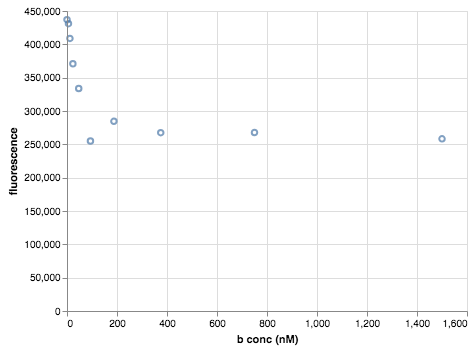

In [4]:
alt.Chart(df).mark_point().encode(
    x = alt.X("b conc (nM)"),
    y = alt.Y("fluorescence"))

LOL I wonder if there are any outliers

Given our known quantities and our goal, the relevant equation is:
\begin{align}
F
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The concentration of a is a set quantity in this experiment and that of b is our independent variabl, so we need parameter estimates of $K_d$, $\hat{f}_0$, and $\hat{f}_q$. Additionally we want to include a Gaussian error term $\sigma$ to reflect errors in measurement. Our priors are as follows:

$$\text{fl} = \text{Norm}(F(c_a^0), \sigma).$$ 

In [5]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

$K_d$ ~ lognorm(1, 3) Given our (limited) knowledge of dissociation constants, we expect $K_d$ to be very small, but do no know the order of magnitude, so we will use a log-normal distribution

$\hat{f}_0$ ~ Norm(500000, 50000) Flourescence is an ununited relative value, but in this experiment it appears to be between 100000 and 500000, so we will choose a distribution with a wide variation at the top of this scale

$\hat{f}_q$ ~ Norm(50000, 5000) We expect quenched molecules to have a much smaller fluorescence than the unquenched molecules, so we will choose a distribution an order of magnitude smaller than that of $\hat{f}_0$

$\sigma$ ~ Half-Norm(0, .5): We expect a variability in measurement of about .1, and to vary from that by about .1. 

Additionally, we know that 
$c_a^0$ = 50 nM

In [6]:
sm = bebi103.stan.StanModel(file='./9.2_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aedbf8ec8e2756c5ef06d2b94e077559 NOW.
/home/ec2-user/miniconda/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpantm9cr1/stanfit4anon_model_aedbf8ec8e2756c5ef06d2b94e077559_4703190534982069862.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [7]:
samples = sm.sampling(data=data, algorithm="Fixed_param",
                          warmup=0,
                          chains=1,
                          iter=1000)

In [8]:
df_gen = bebi103.stan.to_dataframe(samples, diagnostics=False)
df_gen

,chain,chain_idx,warmup,Kd,f0,fq,sigma,ca,F[1],F[2],...,likelihood[2],likelihood[3],likelihood[4],likelihood[5],likelihood[6],likelihood[7],likelihood[8],likelihood[9],likelihood[10],lp__
0,1,1,0,2.377690,9772.860077,896.136075,736.994122,50.0,45533.367738,46308.916682,...,47502.668725,48118.754863,51139.338826,65473.783005,144802.587821,296916.169937,389993.541764,439724.699856,490091.250288,0.0
1,1,2,0,680.914739,9573.817451,873.479306,4861.367930,50.0,181652.837982,254477.558151,...,261705.146945,325391.820107,390943.125618,426840.547801,454394.814590,464810.847962,476475.678603,484380.837441,479644.523705,0.0
2,1,3,0,15.687588,11491.086170,1010.744370,4378.541315,50.0,56143.846346,62005.929200,...,62063.243531,72380.198287,100481.260835,168268.274709,285901.927793,405102.130488,488157.822005,530320.521488,574665.895849,0.0
3,1,4,0,0.031249,11909.205834,900.441912,11638.750914,50.0,45033.958001,45046.667075,...,41467.109978,50509.883300,28135.387642,59439.834913,81072.536339,327513.277972,476393.438796,549281.922958,579398.326129,0.0
4,1,5,0,10.106039,10818.321646,951.746567,298.931525,50.0,51001.065768,54601.229751,...,54477.790501,62838.083992,80938.867426,128021.359966,237267.491453,365566.762676,448386.622588,493912.188532,540762.816870,0.0
5,1,6,0,8.762296,10200.141150,885.895572,282.340352,50.0,47091.580505,50047.280149,...,49865.833803,56104.010455,71542.080398,112286.902481,214311.614364,338803.834345,420148.262727,464571.602974,510039.202170,0.0
6,1,7,0,1.185954,9865.903578,1017.042525,2286.258986,50.0,51213.694248,51600.364173,...,48749.322237,48175.924113,52410.281576,59487.548638,128913.488069,295481.759735,394263.484844,441540.101211,493178.417085,0.0
7,1,8,0,0.726812,11280.955377,994.374551,809.961287,50.0,49976.401033,50252.163159,...,49877.328566,50947.913044,53337.545783,56752.184856,126280.410477,327676.988415,444803.820731,505449.138760,562286.105226,0.0
8,1,9,0,18.513166,11279.658967,942.573651,7256.527530,50.0,53641.736381,60422.125348,...,62463.663086,74722.729927,107870.212265,169177.020300,304019.083203,408555.116358,479807.770831,522279.015335,558944.617742,0.0
9,1,10,0,0.071731,10079.789600,1162.070216,3184.946614,50.0,58125.567613,58149.197216,...,55746.548425,54595.553735,58192.819979,62353.093297,90050.399705,294091.172726,395309.099991,452727.278536,501310.197203,0.0


In [9]:
cols = ["likelihood[1]", "likelihood[2]", "likelihood[3]", "likelihood[4]", "likelihood[5]",
        "likelihood[6]", "likelihood[7]", "likelihood[8]", "likelihood[9]", "likelihood[10]"]

In [10]:
data

{'N': 10,
 'cb': array([1500.      ,  750.      ,  375.      ,  187.5     ,   93.75    ,
          46.875   ,   23.4375  ,   11.71875 ,    5.859375,    0.      ])}

In [11]:
df_gen_fl = df_gen[cols]
df_gen_fl = df_gen_fl.stack(level=0)
df_gen_fl = df_gen_fl.reset_index()
df_gen_fl = df_gen_fl.sort_index(level=1)


# Renaming the columns with useful names
df_gen_fl = df_gen_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

# Renaming the conditions with more descriptive names
for i in range(len(cols)):
    df_gen_fl = df_gen_fl.replace({cols[i]:data['cb'][i]})
    



In [12]:
df_gen_fl.head()

,model,cb,fluorescence signal
0,0,1500.00,45075.818423
1,0,750.00,47502.668725
2,0,375.00,48118.754863
3,0,187.50,51139.338826
4,0,93.75,65473.783005


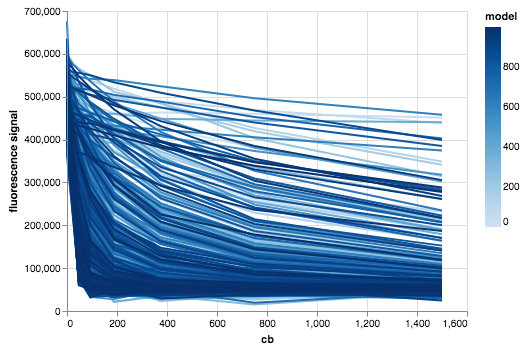

In [13]:
alt.Chart(df_gen_fl).mark_line().encode(
    x = alt.X('cb'),
    y = alt.Y('fluorescence signal'),
    color = alt.Color('model'))
    

In [14]:
sm2 = bebi103.stan.StanModel(file='./9.2_model.stan')

Using cached StanModel.


In [15]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

In [16]:
samples2 = sm2.sampling(data=data)

In [17]:
df2 = bebi103.stan.to_dataframe(samples2, diagnostics=False, inc_warmup=False)

In [18]:
df2.tail()

,chain,chain_idx,warmup,Kd,f0,fq,sigma,fl[1],fl[2],fl[3],...,fl_ppc[2],fl_ppc[3],fl_ppc[4],fl_ppc[5],fl_ppc[6],fl_ppc[7],fl_ppc[8],fl_ppc[9],fl_ppc[10],lp__
3995,4,996,0,7805.683387,394964.544365,56404.360304,9086.819494,1.701526e+07,1.828765e+07,1.897335e+07,...,1.827723e+07,1.895354e+07,1.935643e+07,1.955599e+07,1.963680e+07,1.970491e+07,1.972492e+07,1.973150e+07,1.974735e+07,-104.867085
3996,4,997,0,7594.862199,395111.962345,55376.575002,9003.590914,1.695676e+07,1.825849e+07,1.896019e+07,...,1.823310e+07,1.894648e+07,1.936702e+07,1.957309e+07,1.964541e+07,1.972451e+07,1.973979e+07,1.973827e+07,1.976181e+07,-105.000605
3997,4,998,0,7609.292624,395174.351077,55403.866235,8998.239213,1.698520e+07,1.822796e+07,1.895695e+07,...,1.825139e+07,1.896634e+07,1.934584e+07,1.954256e+07,1.963379e+07,1.969529e+07,1.973392e+07,1.975371e+07,1.976277e+07,-101.777214
3998,4,999,0,6391.007576,409159.708958,50993.459520,4362.163767,1.707919e+07,1.859215e+07,1.947683e+07,...,1.859180e+07,1.947516e+07,1.994609e+07,2.020411e+07,2.033182e+07,2.038611e+07,2.042678e+07,2.044513e+07,2.046522e+07,-93.674691
3999,4,1000,0,6411.739740,409076.270130,50775.159956,4463.413217,1.707553e+07,1.859042e+07,1.948009e+07,...,1.859209e+07,1.947022e+07,1.994828e+07,2.019754e+07,2.032504e+07,2.039544e+07,2.042549e+07,2.043835e+07,2.046095e+07,-94.880267
